In [ ]:
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from wordcloud import WordCloud
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV

Custom Tokenizer Development

In [ ]:
def normalize_repeat(word):
    match = re.search(r"(\w)\1{2,}", word)
    if match:
        char = match.group(1)
        count = len(match.group(0))
        return word[0] + f" <REPEAT:{count}>"
    return word

def tokenize(text):
    text = text.lower()
    text = re.sub(r"\.{2,}", " ... ", text)
    tokens = re.findall(r"[\w']+|[{}]".format(re.escape(string.punctuation)), text)
    return [normalize_repeat(tok) for tok in tokens]

Rule‑Based POS Tagger (Mini Tagger)

In [ ]:
def get_pos(token):
    if re.search(r"(ing|ed)$", token): return "VERB"
    elif re.search(r"ly$", token): return "ADV"
    elif re.search(r"(ness|tion|ity|ment|ism)$", token): return "NOUN"
    elif re.search(r"(ous|ive|able|al)$", token): return "ADJ"
    else: return "UNK"

Custom Lemmatizer

In [ ]:
#Some irregular words and their non stamndard forms which are not easily captured by simple suffix-stripping rules
irregulars = {
    'ran': 'run', 'gone': 'go', 'went': 'go', 'saw': 'see', 'seen': 'see',
    'bought': 'buy', 'brought': 'bring', 'thought': 'think', 'taught': 'teach',
    'better': 'good', 'best': 'good', 'worse': 'bad', 'worst': 'bad',
    'did': 'do', 'done': 'do', 'has': 'have', 'had': 'have',
    'was': 'be', 'were': 'be', 'am': 'be', 'is': 'be', 'are': 'be'
}

def lemmatize(token, pos):
    if token in irregulars:
        return irregulars[token]
    if pos == "VERB" and token.endswith("ing"):
        return token[:-3] if len(token) > 4 else token
    if pos == "VERB" and token.endswith("ed"):
        return token[:-2] if len(token) > 3 else token
    return token

Preprocessing and Feature Extraction

In [ ]:
fake = pd.read_csv("Fake.csv").assign(label=0)
real = pd.read_csv("True.csv").assign(label=1)
data = pd.concat([fake, real]).sample(frac=1).reset_index(drop=True)
data['text'] = data['title'] + ' ' + data['text']

all_tokens = []
final_texts = []

for text in data['text']:
    toks = tokenize(text)
    pos_tags = [get_pos(tok) for tok in toks]
    lemmas = [lemmatize(tok, tag) for tok, tag in zip(toks, pos_tags)]
    all_tokens.extend(lemmas)
    final_texts.append(" ".join(lemmas))

data['processed'] = final_texts

vec = CountVectorizer()
x_counts = vec.fit_transform(data['processed'])
tfidf = TfidfTransformer()
x_tfidf = tfidf.fit_transform(x_counts)
y = data['label']

Model Training and Evaluation


Naive Bayes Results
Accuracy: 0.9345211581291759
Precision: 0.9531174480425326
Recall: 0.909174734900876
F1: 0.930627654554035


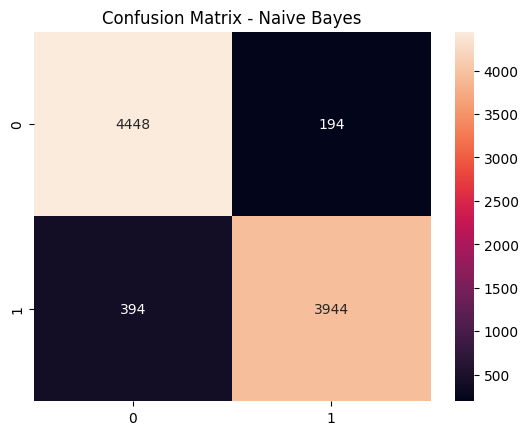

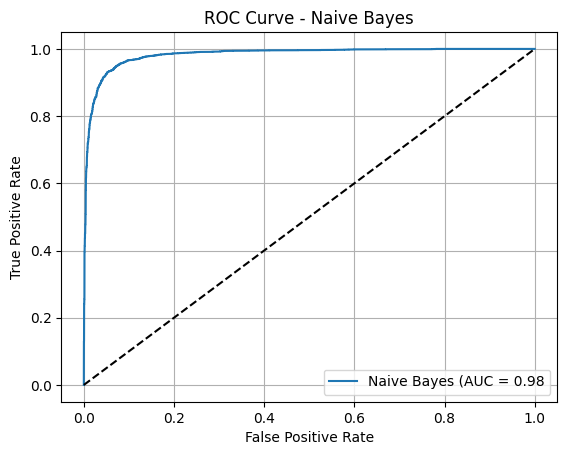


SVM (No ROC) Results
Accuracy: 0.9953229398663697
Precision: 0.9956160590678357
Recall: 0.9946980175195943
F1: 0.9951568265682657


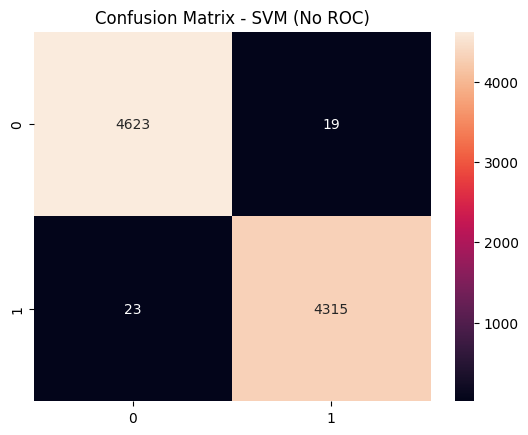


SVM (With ROC) Results
Accuracy: 0.9948775055679288
Precision: 0.9944700460829493
Recall: 0.9949285384970032
F1: 0.9946992394560958


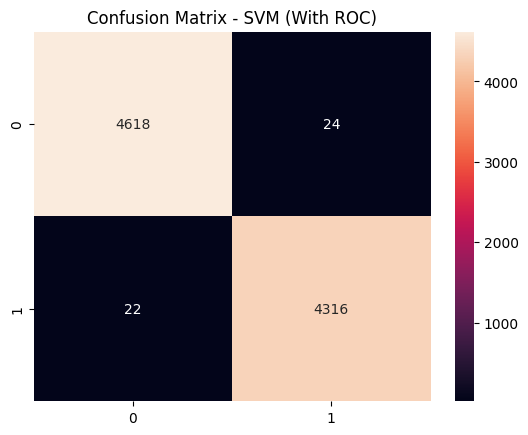

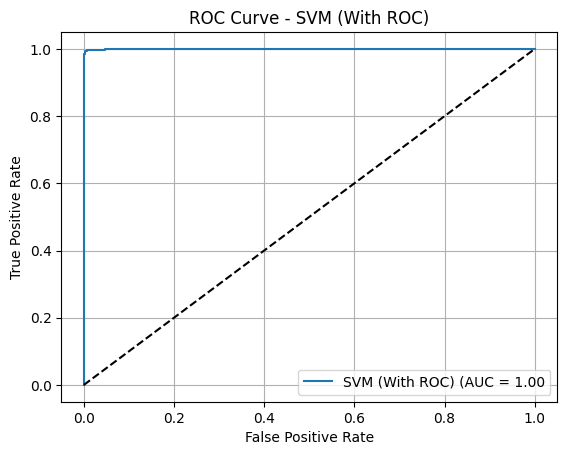

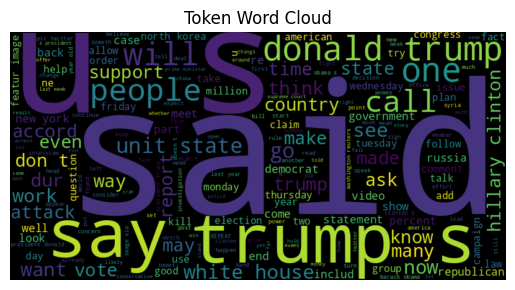

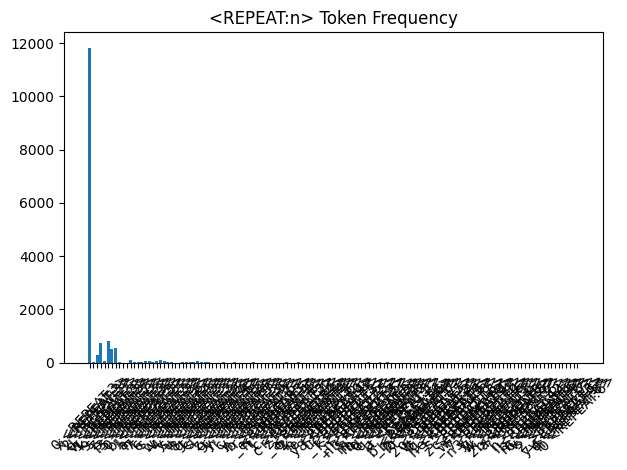

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_tfidf, y, test_size=0.2, random_state=42)

nb = MultinomialNB()
svm_raw = LinearSVC()
svm_cal = CalibratedClassifierCV(LinearSVC(), cv=3)
nb.fit(x_train, y_train)
svm_raw.fit(x_train, y_train)
svm_cal.fit(x_train, y_train)


def evaluate(model, name, proba_func=None):
    preds = model.predict(x_test)
    print(f"\n{name} Results")
    print("Accuracy:", accuracy_score(y_test, preds))
    print("Precision:", precision_score(y_test, preds))
    print("Recall:", recall_score(y_test, preds))
    print("F1:", f1_score(y_test, preds))
    sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt='d')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    if proba_func:
        y_score = proba_func(x_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {name}')
        plt.legend()
        plt.grid(True)
        plt.show()

evaluate(nb, "Naive Bayes", proba_func=nb.predict_proba)

# LinearSVC does not have predict_proba so skipped ROC
evaluate(svm_raw, "SVM (No ROC)")
#LinearSVC doesn’t support probability predictions by default → ROC curve for SVM added by wrappingLinearSVC with CalibratedClassifierCV.
evaluate(svm_cal, "SVM (With ROC)", proba_func=svm_cal.predict_proba)

# Visualizations
wordcloud = WordCloud(width=800, height=400).generate(" ".join(all_tokens))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Token Word Cloud")
plt.show()

repeats = [t for t in all_tokens if '<REPEAT:' in t]
repeat_counts = Counter(repeats)
plt.bar(*zip(*repeat_counts.items()))
plt.xticks(rotation=45)
plt.title("<REPEAT:n> Token Frequency")
plt.tight_layout()
plt.show()
